# To run if on Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import shutil
import zipfile
import os

file_name = 'Dataset_TXA.zip'

# copying the dataset to the temporary workspace
print('Copying Dataset to temporary workspace...')
shutil.copyfile('drive/MyDrive/Dataset_TXA.zip', 'Dataset_TXA.zip')
print('Copied...')

# unzipping the dataset
path = 'Dataset'
with zipfile.ZipFile(file_name, 'r') as zip_ref:
    zip_ref.extractall(path)

#moving inside the Dataset folder
os.chdir(path)
os.getcwd()

Mounted at /content/drive
Copying Dataset to temporary workspace...
Copied...


'/content/Dataset'

In [2]:
!pip install swifter
!pip install wordcloud
!pip install gensim
!pip install transformers
!pip install spacy
!pip install umap-learn
!spacy download en_core_web_sm

# to remove the output of the installation
from IPython.display import clear_output
clear_output(wait=True)
print('Set up complete')

Set up complete


# Importing the Libraries

In [6]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import swifter

default_params = mpl.rcParamsDefault

import re
import time
from collections import Counter

import requests
from bs4 import BeautifulSoup

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords

# Pos tagging correspondence
from nltk.corpus import wordnet

# Stop words
from gensim.parsing.preprocessing import remove_stopwords, STOPWORDS
# Compute bigrams.
from gensim.models import Phrases
# Utility to compute dictionary
from gensim.corpora import Dictionary

import spacy

# Ner visualization
from spacy import displacy

import torch

from wordcloud import WordCloud
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Split the documents into tokens.
from nltk.tokenize import RegexpTokenizer

# Lemmatize the documents.
from nltk.stem.wordnet import WordNetLemmatizer

# Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Topic Distribution with UMAP and tSNE
from yellowbrick.text import UMAPVisualizer
from yellowbrick.text import TSNEVisualizer

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

stop_words = set(STOPWORDS)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [7]:
# cleaning different patterns
def clean_tokens(tokens):
    tokens = re.sub(r'[^\w\s]', '', tokens)
    tokens = re.sub(r'<.*?>', '', tokens) #removing HTMLS
    tokens = re.sub(r"\\", "", tokens) #removing \ character
    tokens = re.sub(r"\n", "", tokens)
    tokens = re.sub(r"http\S+", "", tokens) #removing HTTPS
    tokens = re.sub(r'\b\d+\b', '', tokens) #removing numbers
    
    return tokens.strip().lower()

In [8]:
#cleaning stopwords and words containing non alphanumeric characters
def remove_stop_words(column, pos = False):
    """
    It removes the stop words from a column or an iterable of tokens, 
    the pos parameter specify if the pos is present in the iterable.
    e.g. pos == True iff [(holy, JJ), (crap, NN), (awesome, NN) <-- [0] word, [1] pos

    """

    if pos == False:
        return [[token for token in review_text if (token not in stop_words) and token.isalpha()] for review_text in column]
    else: #token[0] because it is assumed the token is the first position of the tuple
        return [[token for token in review_text if (token[0] not in stop_words) and token[0].isalpha()] for review_text in column]

In [9]:
# to interpret the postag to wordnet lexicon

def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# Loading the Training Set

In [10]:
df = pd.read_csv("gr_training_set.csv")

In [11]:
df.tail()

,user_id,book_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments,genre
899995,b9450d1c1f97f891c392b1105959b56e,11832081,7c34c15ad8cb28a4afca32946e2016ea,3,3.5 stars. \n Jenna is a popular YA author and...,Fri Nov 16 22:10:17 -0800 2012,Sat Nov 17 22:42:44 -0800 2012,Sat Nov 17 00:00:00 -0800 2012,Fri Nov 16 00:00:00 -0800 2012,0,0,Romance
899996,b9450d1c1f97f891c392b1105959b56e,16095092,e979c735276431915d089cfaf446d64f,3,This was a quick read for me. I have read a lo...,Fri Nov 16 22:09:49 -0800 2012,Sat Nov 17 23:38:58 -0800 2012,Sat Nov 17 00:00:00 -0800 2012,Fri Nov 16 00:00:00 -0800 2012,1,1,NaN
899997,b9450d1c1f97f891c392b1105959b56e,8430896,feb9fe6439f9fbba8a1cce36020ad977,4,** spoiler alert ** \n 3.5 stars. \n This book...,Tue Nov 13 05:38:24 -0800 2012,Tue Nov 13 23:29:17 -0800 2012,Tue Nov 13 00:00:00 -0800 2012,Tue Nov 13 00:00:00 -0800 2012,1,0,Young Adult
899998,b9450d1c1f97f891c392b1105959b56e,12275680,741e29369f70531bfffbd02add86f228,4,** spoiler alert ** \n Another fun read from M...,Mon Nov 12 05:42:30 -0800 2012,Tue Nov 13 22:32:05 -0800 2012,Tue Nov 13 00:00:00 -0800 2012,Mon Nov 12 00:00:00 -0800 2012,0,0,Mystery
899999,b9450d1c1f97f891c392b1105959b56e,17005,d55f3a967230940e75a314700caec9a5,3,** spoiler alert ** \n 3.5 stars \n I liked it...,Sun Nov 11 00:05:43 -0800 2012,Sun Nov 11 21:59:08 -0800 2012,Sun Nov 11 00:00:00 -0800 2012,Sun Nov 11 00:00:00 -0800 2012,0,0,Young Adult


# Checking Users' behaviour
If some users reviewed too many books and if the users reviewed the same books more than once

In [12]:
dist_user_reviews = sorted(list(df.user_id.value_counts().items()),
                           key = lambda x: -x[1]) #sorting on count

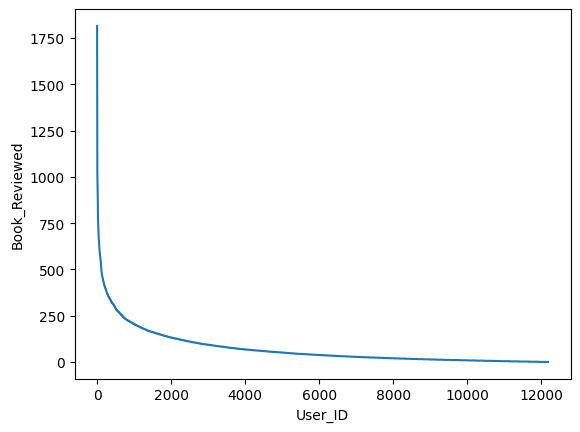

In [13]:
# setting default matplotlib plot style
mpl.rcParams.update(default_params)

# conclusion: power law of a few users with lots of reviews
plt.plot([x[1] for x in dist_user_reviews])
plt.ylabel('Book_Reviewed')
plt.xlabel('User_ID')
plt.show()

In [14]:
book_per_user = df.groupby(['user_id', 'book_id']).count()['review_id']
book_per_user

user_id                           book_id 
000a1016fda6008d1edbba720ca00851  178476      1
                                  215643      1
                                  458034      1
                                  3863861     1
                                  6040871     1
                                             ..
ffff7cafdaf5196383cb2efca08fb6fe  27161826    1
                                  27272506    1
                                  28260587    1
                                  28954189    1
                                  32571395    1
Name: review_id, Length: 900000, dtype: int64

In [15]:
# no review of the same book
book_per_user.max()

1

# Balancing reviews per book
Sampling reviews pertaining to books with too many reviews

In [16]:
df['n_review_per_book'] = df.groupby('book_id')['book_id'].transform(len)

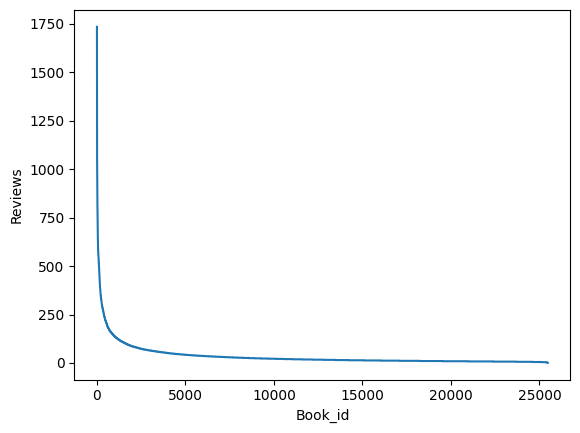

In [17]:
# too many reviews for some books, they need some balancing
reviews_x_book = [x[1] for x in sorted(list(set([(x, y) for x, y in df[['book_id', 'n_review_per_book']].values])),
                                       key = lambda x: -x[1])]
                                       
plt.plot(reviews_x_book)
plt.ylabel('Reviews')
plt.xlabel('Book_id')
plt.show()

In [18]:
#average number of reviews per book
average_rev = int(sum(reviews_x_book) / len(reviews_x_book) // 1)
average_rev

35

In [19]:
indexes_to_keep = df[df['n_review_per_book'] <= average_rev].index
index_sampled = df[df['n_review_per_book'] > average_rev].groupby('book_id').sample(average_rev, random_state = 42).index

new_indexes = sorted(indexes_to_keep.tolist()+index_sampled.tolist())

In [20]:
df = df.loc[new_indexes].reset_index(drop=True)
len(df)

501745

# Dropping NaN genres

In [21]:
#Dropping NaN values
print(f"NaN values: {df.genre.isna().sum()}")
df.dropna(subset=['genre'], inplace=True)
print(f"NaN values: {df.genre.isna().sum()}")

NaN values: 71220
NaN values: 0


In [22]:
df_len = len(df)
print(f'New Dataset Length: {df_len}')

New Dataset Length: 430525


# Storing the new training set

In [23]:
rev_df = df[["review_text","genre", "rating", "book_id"]]
#del df

In [24]:
rev_df.head()

,review_text,genre,rating,book_id
0,This is a special book. It started slow for ab...,Science Fiction,5,18245960
1,Recommended by Don Katz. Avail for free in Dec...,Classics,3,16981
2,"A fun, fast paced science fiction thriller. I ...",Science Fiction,3,28684704
3,"I really enjoyed this book, and there is a lot...",Science Fiction,4,25884323
6,A beautiful story. Neil Gaiman is truly a uniq...,Fantasy,5,5577844


In [25]:
len(rev_df)

430525

# Balancing the genres

In [26]:
list(enumerate(rev_df.genre.value_counts().items()))[:10]

[(0, ('Romance', 110224)),
 (1, ('Fantasy', 99576)),
 (2, ('Young Adult', 63176)),
 (3, ('Fiction', 28783)),
 (4, ('Science Fiction', 19808)),
 (5, ('Mystery', 17766)),
 (6, ('Sequential Art', 17078)),
 (7, ('Historical', 12771)),
 (8, ('Horror', 9878)),
 (9, ('Classics', 7518))]

In [27]:
# made it slightly more readable
genres_corresp = ((("Fantasy", "Superheroes", "Shapeshifters", "Science Fiction Fantasy"), #-->
                   ("Fantasy")),
                  (("Romance", "Erotica", "Polyamorous", "Category Romance"), #-->
                   ("Romance")),
                  (("Fiction", "Young Adult", "New Adult", "Womens Fiction", "Adult Fiction", 
                    "Christian Fiction", "Realistic Fiction", "Fan Fiction", "Magical Realism"), #-->
                   ("Fiction")),
                  (("Sequential Art", "Music", "Couture"), #-->
                   ("Art")),
                  (("Thriller", "Mystery", "Crime"), #-->
                   ("Thriller")),
                  (("Science Fiction", ), #just add a single comma to not loop in the string -->
                   ("Science Fiction")),
                  (("Horror", "Paranormal", "Dark", "Suspense"), #-->
                   ("Horror")),
                  (("Classics", "Contemporary", "Poetry", "Plays"), #-->
                   ("Literature")),
                  (("Nonfiction", "Autobiography", "Biography"), #-->
                   ("NonFiction")),
                  (("Historical", "History", "War", "Mythology"), #-->
                   ("History")))

In [28]:
genres_to_keep_dict = {k : v for ks, v in genres_corresp for k in ks}
genres_to_keep_dict

{'Fantasy': 'Fantasy',
 'Superheroes': 'Fantasy',
 'Shapeshifters': 'Fantasy',
 'Science Fiction Fantasy': 'Fantasy',
 'Romance': 'Romance',
 'Erotica': 'Romance',
 'Polyamorous': 'Romance',
 'Category Romance': 'Romance',
 'Fiction': 'Fiction',
 'Young Adult': 'Fiction',
 'New Adult': 'Fiction',
 'Womens Fiction': 'Fiction',
 'Adult Fiction': 'Fiction',
 'Christian Fiction': 'Fiction',
 'Realistic Fiction': 'Fiction',
 'Fan Fiction': 'Fiction',
 'Magical Realism': 'Fiction',
 'Sequential Art': 'Art',
 'Music': 'Art',
 'Couture': 'Art',
 'Thriller': 'Thriller',
 'Mystery': 'Thriller',
 'Crime': 'Thriller',
 'Science Fiction': 'Science Fiction',
 'Horror': 'Horror',
 'Paranormal': 'Horror',
 'Dark': 'Horror',
 'Suspense': 'Horror',
 'Classics': 'Literature',
 'Contemporary': 'Literature',
 'Poetry': 'Literature',
 'Plays': 'Literature',
 'Nonfiction': 'NonFiction',
 'Autobiography': 'NonFiction',
 'Biography': 'NonFiction',
 'Historical': 'History',
 'History': 'History',
 'War': 'Histo

In [29]:
print(f"Initial rows: {len(rev_df)}")
rev_df = rev_df[rev_df.genre.isin(genres_to_keep_dict.keys())].reset_index(drop=True)
print(f"Filtered len: {len(rev_df)}")

Initial rows: 430525
Filtered len: 420214


In [30]:
rev_df.genre = rev_df.genre.map(lambda genere: genres_to_keep_dict[genere])
rev_df.head()

,review_text,genre,rating,book_id
0,This is a special book. It started slow for ab...,Science Fiction,5,18245960
1,Recommended by Don Katz. Avail for free in Dec...,Literature,3,16981
2,"A fun, fast paced science fiction thriller. I ...",Science Fiction,3,28684704
3,"I really enjoyed this book, and there is a lot...",Science Fiction,4,25884323
4,A beautiful story. Neil Gaiman is truly a uniq...,Fantasy,5,5577844


In [31]:
rev_df.genre.value_counts()

Romance            113261
Fiction            102767
Fantasy             99660
Thriller            21056
Science Fiction     19808
Horror              18046
Art                 17111
History             13436
Literature           9729
NonFiction           5340
Name: genre, dtype: int64

# Class Undersampling

In [32]:
n = 2000
genres_w_more_than_n_reviews = rev_df.groupby('genre')['genre'].transform(len) >= n
#undersampling genres with more than 2000 reviews to 2000
rev_df_reduced = pd.concat((rev_df[genres_w_more_than_n_reviews].groupby('genre').sample(n=n, random_state = 42), 
                            rev_df[~genres_w_more_than_n_reviews]), ignore_index=True)

In [33]:
rev_df_reduced.genre.value_counts()

Art                2000
Fantasy            2000
Fiction            2000
History            2000
Horror             2000
Literature         2000
NonFiction         2000
Romance            2000
Science Fiction    2000
Thriller           2000
Name: genre, dtype: int64

# Plotting Genres distribution

In [34]:
# setting default matplotlib plot style
mpl.rcParams.update(default_params)

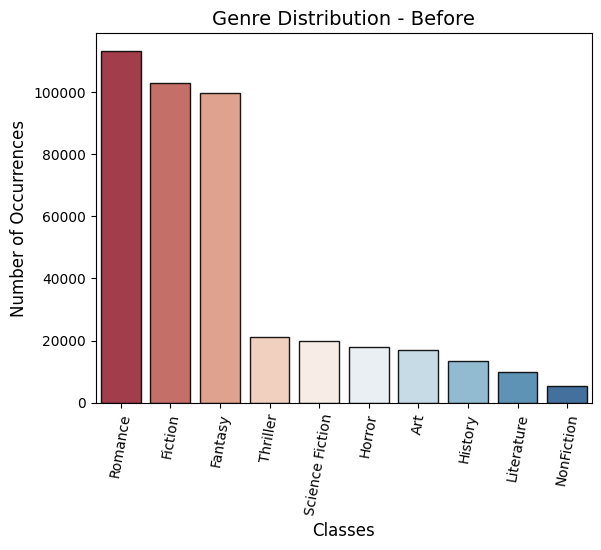

In [35]:
sns.barplot([x for x in rev_df.genre.value_counts().index],
            [y for y in rev_df.genre.value_counts().values],
            alpha=0.9, palette="RdBu", edgecolor="black")

plt.title('Genre Distribution - Before',fontsize=14)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Classes', fontsize=12)
plt.xticks(rotation=80)
plt.show()

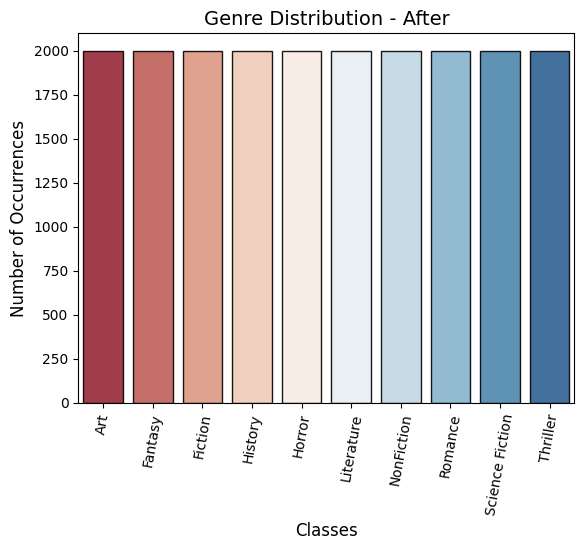

In [36]:
sns.barplot([x for x in rev_df_reduced.genre.value_counts().index],
            [y for y in rev_df_reduced.genre.value_counts().values],
            alpha=0.9, palette="RdBu", edgecolor="black")

plt.title('Genre Distribution - After',fontsize=14)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Classes', fontsize=12)
plt.xticks(rotation=80)
plt.show()

# NER

Before cleaning the review texts, NER and chuncking are applied on some reviews

In [39]:
#load spacy model 
nlp = spacy.load("en_core_web_sm")

In [40]:
rev_df['review_text'].transform(lambda x: len(x.split()))[:21]

0     368
1      10
2     468
3     736
4     282
5     419
6     483
7     322
8     299
9      42
10     97
11    118
12    152
13    114
14     42
15    186
16    101
17     12
18     10
19     20
20    117
Name: review_text, dtype: int64

In [41]:
# Doc example for chunking and NER visualization
doc = nlp(rev_df.review_text[16])

In [42]:
# Chunking 
[chunk.text for chunk in doc.noun_chunks]

['it',
 'I',
 'a book store',
 'Its a Harry Potter reading level',
 'similar type fantasy story',
 'that',
 'what',
 'you',
 'a long flight',
 'NYC',
 'the holidays',
 'I',
 'a child',
 'we',
 'all',
 'alternate worlds',
 'I',
 'that',
 'the basis',
 'the book',
 'all the permutations',
 'things',
 'I',
 'I',
 'a Daemon',
 'I',
 'she',
 'a lynx']

In [43]:
for entity in doc.ents:
  print(entity.text, entity.label_)

second ORDINAL
two CARDINAL
Harry Potter PERSON
NYC LOC
the holidays DATE


In [46]:
# The 'ent' style shows a named entity visualization
displacy.render(doc, style="ent", jupyter=True )

In [48]:
# Doc example for dependency parse tree
example = nlp(rev_df.review_text[18])

In [49]:
# The 'dep' style shows a dependency parse tree with POS(Part-of-Speech) tags and syntactic dependencies 
displacy.render(example, style="dep", jupyter=True, options= {'distance': 110} )

# Cleaning Text

In [50]:
#cleaning review_text col
rev_df = rev_df_reduced
rev_df.review_text = rev_df.review_text.swifter.apply(lambda x: clean_tokens(x))
rev_df.head()

Pandas Apply:   0%|          | 0/20000 [00:00<?, ?it/s]

,review_text,genre,rating,book_id
0,governor gets his comeuppance and the gang fin...,Art,3,138395
1,i originally read these graphic novels back in...,Art,4,234352
2,i like that i hear all the character voices as...,Art,3,133765
3,i an not accurately describe how beautiful the...,Art,5,29633708
4,all things must come to an end and unfortunate...,Art,4,25104


# Tokeninzing the Text

In [51]:
rev_df["tokenized_text"] = rev_df.review_text.swifter.apply(lambda x: word_tokenize(x))
rev_df.head()

Pandas Apply:   0%|          | 0/20000 [00:00<?, ?it/s]

,review_text,genre,rating,book_id,tokenized_text
0,governor gets his comeuppance and the gang fin...,Art,3,138395,"[governor, gets, his, comeuppance, and, the, g..."
1,i originally read these graphic novels back in...,Art,4,234352,"[i, originally, read, these, graphic, novels, ..."
2,i like that i hear all the character voices as...,Art,3,133765,"[i, like, that, i, hear, all, the, character, ..."
3,i an not accurately describe how beautiful the...,Art,5,29633708,"[i, an, not, accurately, describe, how, beauti..."
4,all things must come to an end and unfortunate...,Art,4,25104,"[all, things, must, come, to, an, end, and, un..."


# POS tagging

The Part Of Speech tag. Valid options are `"n"` for nouns, `"v"` for verbs, `"a"` for adjectives, `"r"` for adverbs and `"s"` for satellite adjectives.

In [52]:
rev_df["postagged_text"] = rev_df.tokenized_text.swifter.apply(lambda x: nltk.pos_tag(x))

Pandas Apply:   0%|          | 0/20000 [00:00<?, ?it/s]

In [53]:
list_of_tags = rev_df.postagged_text.swifter.apply(lambda x: [el[1] for el in x if len(el) == 2]).tolist()
set_of_tags = set()

for ls in list_of_tags:
    for tag in ls:
        set_of_tags.add(tag)

Pandas Apply:   0%|          | 0/20000 [00:00<?, ?it/s]

In [54]:
pos_mapper = {k : get_wordnet_pos(k) for k in set_of_tags}

In [55]:
list(pos_mapper.items())[:5]

[('EX', None), ('RB', 'r'), ('RBR', 'r'), ('CD', None), ('JJS', 'a')]

# Removing Stop Words

In [56]:
print(f"e.g. a token list len before: {len(rev_df.tokenized_text[0])}")
rev_df["tokenized_text"] = remove_stop_words(rev_df["tokenized_text"], pos = False)
print(f"e.g. a token list len after: {len(rev_df.tokenized_text[0])}")

e.g. a token list len before: 233
e.g. a token list len after: 103


In [57]:
print(f"e.g. a token list len before: {len(rev_df.postagged_text[0])}")
rev_df["postagged_text"] = remove_stop_words(rev_df["postagged_text"], pos = True)
print(f"e.g. a token list len after: {len(rev_df.postagged_text[0])}")

e.g. a token list len before: 233
e.g. a token list len after: 103


# Filtering out short words

In [58]:
rev_df.head()

,review_text,genre,rating,book_id,tokenized_text,postagged_text
0,governor gets his comeuppance and the gang fin...,Art,3,138395,"[governor, gets, comeuppance, gang, way, woodb...","[(governor, NN), (gets, VBZ), (comeuppance, NN..."
1,i originally read these graphic novels back in...,Art,4,234352,"[originally, read, graphic, novels, f, got, de...","[(originally, RB), (read, VB), (graphic, JJ), ..."
2,i like that i hear all the character voices as...,Art,3,133765,"[like, hear, character, voices, read, honestly...","[(like, IN), (hear, VBP), (character, NN), (vo..."
3,i an not accurately describe how beautiful the...,Art,5,29633708,"[accurately, beautiful, illustrations, colors,...","[(accurately, RB), (beautiful, JJ), (illustrat..."
4,all things must come to an end and unfortunate...,Art,4,25104,"[things, come, end, unfortunately, sandman, bo...","[(things, NNS), (come, VB), (end, NN), (unfort..."


In [59]:
# minimum length of the remaining words of the fixed tokenized text 
print('Minimum Length of a Word in the Dataset:', end=' ')
min([min(x) for x in rev_df.postagged_text.map(lambda x: ([len(el[0]) for el in x])) if x != []])

Minimum Length of a Word in the Dataset: 

1

In [60]:
#filtering the words with a length less than 4
rev_df["tokenized_text"] = rev_df.tokenized_text.map(lambda x: [el for el in x if len(el) > 3])
rev_df["postagged_text"] = rev_df.postagged_text.map(lambda x: [el for el in x if len(el[0]) > 3])

Checking if both the tokenized text and the postagged one matches the new filtering

In [61]:
# minimum length of the remaining words of the fixed tokenized text after update
print('Minimum Length of a Word in the Dataset:', end=' ')
min([min(x) for x in rev_df.tokenized_text.map(lambda x: ([len(el) for el in x])) if x != []])

Minimum Length of a Word in the Dataset: 

4

In [62]:
# minimum length of the remaining words of the fixed tokenized text after update
print('Minimum Length of a Word in the Dataset:', end=' ')
min([min(x) for x in rev_df.postagged_text.map(lambda x: ([len(el[0]) for el in x])) if x != []])

Minimum Length of a Word in the Dataset: 

4

# Lemmatize the Tokens

In [63]:
def lemmatize_row(row):
    lemmatizer = WordNetLemmatizer()
    lemmatized_row = list()
    
    for token, pos in row:
        if pos_mapper[pos] is None:
            lemma = lemmatizer.lemmatize(token)
        else:
            lemma = lemmatizer.lemmatize(token, pos = pos_mapper[pos])

        lemmatized_row.append(lemma) # we discarded the pos here

    return lemmatized_row

In [64]:
#lemmatizing
rev_df['lemmatized_text'] = rev_df.postagged_text.swifter.apply(lambda x: lemmatize_row(x))

Pandas Apply:   0%|          | 0/20000 [00:00<?, ?it/s]

In [65]:
rev_df.head()

,review_text,genre,rating,book_id,tokenized_text,postagged_text,lemmatized_text
0,governor gets his comeuppance and the gang fin...,Art,3,138395,"[governor, gets, comeuppance, gang, woodbury, ...","[(governor, NN), (gets, VBZ), (comeuppance, NN...","[governor, get, comeuppance, gang, woodbury, t..."
1,i originally read these graphic novels back in...,Art,4,234352,"[originally, read, graphic, novels, deluxe, co...","[(originally, RB), (read, VB), (graphic, JJ), ...","[originally, read, graphic, novel, deluxe, cop..."
2,i like that i hear all the character voices as...,Art,3,133765,"[like, hear, character, voices, read, honestly...","[(like, IN), (hear, VBP), (character, NN), (vo...","[like, hear, character, voice, read, honestly,..."
3,i an not accurately describe how beautiful the...,Art,5,29633708,"[accurately, beautiful, illustrations, colors,...","[(accurately, RB), (beautiful, JJ), (illustrat...","[accurately, beautiful, illustration, color, b..."
4,all things must come to an end and unfortunate...,Art,4,25104,"[things, come, unfortunately, sandman, book, f...","[(things, NNS), (come, VB), (unfortunately, RB...","[thing, come, unfortunately, sandman, book, fe..."


# Extracting Dictionary 

In [66]:
dict_count = dict(sorted(nltk.FreqDist([word for text in rev_df["lemmatized_text"] for word in text]).items(), 
                         key=lambda x: x[1], reverse=True))

In [67]:
list(dict_count.items())[:6]

[('book', 39561),
 ('read', 20974),
 ('like', 19223),
 ('story', 16951),
 ('love', 15062),
 ('character', 14196)]

In [68]:
# getting the max frequency of a word that appear in at most 99% of the review corpus 
maximum_threshold = np.quantile(list(dict_count.values()), 0.99)

In [69]:
# filtering out the extremes of the distribution
dict_count_fixed = {k:v for k,v in dict_count.items() if v > 5 and v < maximum_threshold}
# dict_count_fixed

In [70]:
dictionary = set(dict_count_fixed.keys())
# dictionary
len(dictionary)

13667

# Topic Distribution

In [71]:
# Instantiating the vectorizer
tfidf = TfidfVectorizer()

In [72]:
# joining the text back to a string
rev_df['lemmatized_joined'] = rev_df["lemmatized_text"].swifter.apply(lambda x: ' '.join(x))

# setting the corpus and the labels
corpus = rev_df["lemmatized_joined"]
labels = rev_df['genre']

# vectorizing
matrix = tfidf.fit_transform(corpus)

Pandas Apply:   0%|          | 0/20000 [00:00<?, ?it/s]

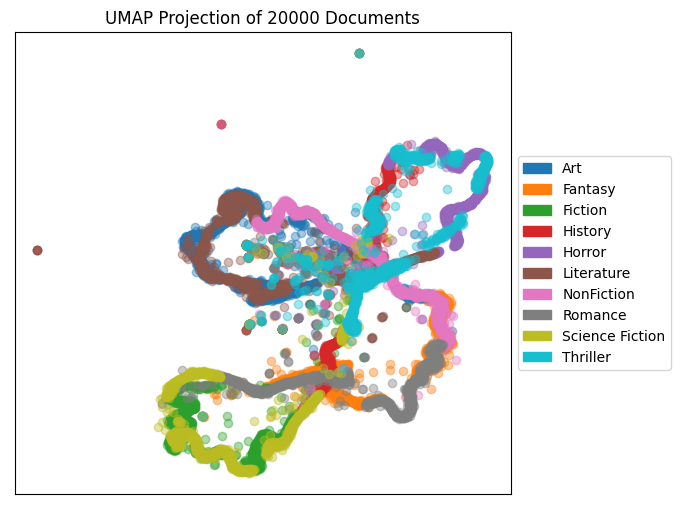

In [73]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
umap = UMAPVisualizer(ax = ax, alpha = 0.4)
umap.fit(matrix, labels, random_state = 42)
umap.show()

Nothing that relevant for the tSNE

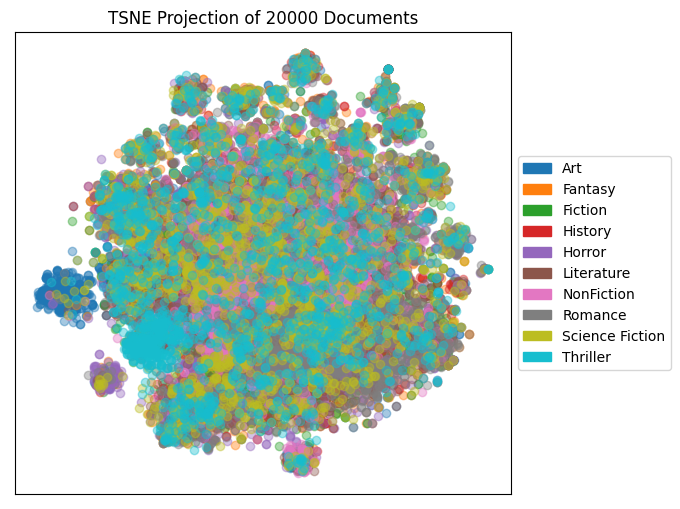

In [74]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
tsne = TSNEVisualizer(ax = ax, alpha = 0.4)
tsne.fit(matrix, labels, random_state = 42)
tsne.show()

# Topic Modeling

In [75]:
lemma_docs = rev_df["lemmatized_text"].values.tolist()

# Add bigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(lemma_docs, min_count=20)

for idx in range(len(lemma_docs)):
    for token in bigram[lemma_docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            # I keep both single words and bigrams in the document
            lemma_docs[idx].append(token)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [76]:
alternative_dictionary = Dictionary(lemma_docs)
print('Before Removal', len(alternative_dictionary))
# Filter out words that occur less than 5 documents, or more than 70% of the documents.
alternative_dictionary.filter_extremes(no_below=5, no_above=0.70)
print('After Removal', len(alternative_dictionary))

Before Removal 60650
After Removal 14708


In [77]:
# Bag-of-words representation of the documents.
corpus = [alternative_dictionary.doc2bow(doc) for doc in lemma_docs]

In [78]:
for key, idxinfo in zip([alternative_dictionary[w[0]] for w in corpus[5]], corpus[5]):
    print (key, idxinfo)

character (5, 1)
come (7, 1)
issue (87, 2)
read (100, 2)
volume (106, 1)
happens (178, 1)
happy (179, 1)
hop (180, 1)
jump (181, 1)
plot (182, 1)
wasnt (183, 1)


In [79]:
print(f'Number of unique tokens: {len(alternative_dictionary)}')
print(f'Number of documents: {len(corpus)}')

Number of unique tokens: 14708
Number of documents: 20000


In [80]:
# Train LDA model.
from gensim.models import LdaModel

# Set training parameters.
num_topics = len(np.unique(rev_df['genre']))
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make an index to word dictionary.
temp = alternative_dictionary[0]  # This is only to "load" the dictionary.
id2word = alternative_dictionary.id2token

model = LdaModel(corpus=corpus,
                 id2word=id2word,
                 chunksize=chunksize,
                 alpha='auto',
                 eta='auto',
                 iterations=iterations,
                 num_topics=num_topics,
                 passes=passes,
                 eval_every=eval_every
                 )

In [81]:
top_topics = model.top_topics(corpus)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print(f'Average topic coherence: {avg_topic_coherence:.4f}.')

Average topic coherence: -3.3282.


I see some words which appear in a lot of books going to the same topic, while I can recognize some thriller and romance -like words...

In [82]:
for topic in top_topics:
    print('\n', topic[1], [w[1] for w in topic[0]])


 -1.109323993693616 ['book', 'read', 'like', 'character', 'story', 'love', 'think', 'good', 'time', 'didnt', 'know', 'thing', 'dont', 'series', 'go', 'enjoy', 'feel', 'little', 'star', 'want']

 -1.441405086254939 ['love', 'want', 'know', 'life', 'friend', 'shes', 'girl', 'come', 'family', 'heart', 'relationship', 'go', 'help', 'doesnt', 'away', 'need', 'mother', 'leave', 'thing', 'take']

 -1.6986530929008214 ['people', 'world', 'human', 'work', 'idea', 'fiction', 'science', 'make', 'point', 'doesnt', 'thing', 'think', 'game', 'like', 'play', 'say', 'problem', 'fact', 'mean', 'question']

 -1.9225210525610188 ['novel', 'story', 'life', 'reader', 'time', 'write', 'young', 'child', 'experience', 'year', 'author', 'tell', 'work', 'family', 'woman', 'tale', 'school', 'beautiful', 'true', 'small']

 -2.6765795121409495 ['mystery', 'murder', 'case', 'crime', 'police', 'world', 'follow', 'lead', 'involve', 'solve', 'secret', 'event', 'grace', 'detective', 'reveal', 'kill', 'future', 'holmes

# Considerations on TF-IDF values on unigrams, bigrams and trigrams

In [83]:
# convert into numpy array with todense()
tfidf_values = pd.DataFrame(matrix[32].T.todense(),
                            index=tfidf.get_feature_names(), columns=["TF-IDF"]) 
tfidf_values = tfidf_values.sort_values('TF-IDF', ascending=False)
tfidf_values[:10]

,TF-IDF
trajectory,0.369254
lemire,0.365477
xmen,0.325698
fee,0.296336
slap,0.294889
marvel,0.267742
war,0.262713
assume,0.234528
ruin,0.231122
awesome,0.188644


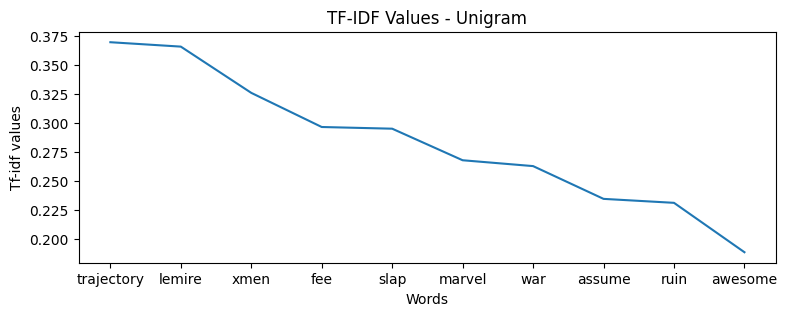

In [84]:
p = [x for x in tfidf_values.values][:10]
n = [x for x in tfidf_values.index][:10]
plt.figure(figsize=(9,3))
plt.title("TF-IDF Values - Unigram")
plt.xlabel("Words")
plt.ylabel("Tf-idf values")
plt.plot(n,p)
plt.show()


The higher the TF-IDF score the more important/ relevant the term is. When a term gets less relevant, its TF-IDF score will tend to 0.Considering the unigram case, in this case the words related to Comics (i.e. xmen, marvel and the cartoonist and artist Lemire) have the highest TF-IDF values.

In [88]:
corpus = rev_df['lemmatized_joined']

In [89]:
# initialize tfidf considering bigrams
tfidf_bi = TfidfVectorizer(ngram_range = (2,2))
matrix_bi = tfidf_bi.fit_transform(corpus)

tfidf_values_bi = pd.DataFrame(matrix_bi[32].T.todense(),
                               index=tfidf_bi.get_feature_names(), columns=["TF-IDF_Bigrams"]) 
tfidf_values_bi = tfidf_values_bi.sort_values('TF-IDF_Bigrams', ascending=False)
tfidf_values_bi[:10]

,TF-IDF_Bigrams
xmen leave,0.260251
assume problem,0.260251
trajectory secret,0.260251
fee like,0.260251
lemire xmen,0.260251
ruin fee,0.260251
marvel high,0.260251
awesome trajectory,0.260251
high lemire,0.260251
war ruin,0.260251


In [90]:
# initialize tfidf considering bigrams
tfidf_tri = TfidfVectorizer(ngram_range = (3,3))
matrix_tri = tfidf_tri.fit_transform(corpus)

tfidf_values_tri = pd.DataFrame(matrix_tri[32].T.todense(),
                                index=tfidf_tri.get_feature_names(), columns=["TF-IDF_Trigrams"]) 
tfidf_values_tri = tfidf_values_tri.sort_values('TF-IDF_Trigrams', ascending=False)
tfidf_values_tri[:10]

,TF-IDF_Trigrams
lemire xmen leave,0.25
ruin fee like,0.25
problem book come,0.25
like slap face,0.25
fee like slap,0.25
marvel high lemire,0.25
leave awesome trajectory,0.25
trajectory secret war,0.25
xmen leave awesome,0.25
come marvel high,0.25


In both bigrams and trigrams , the tf-idf values are similar

# Sentiment Analysis on Sample

In [91]:
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

def sentiment_score(review):
    tokens = tokenizer.encode(review, return_tensors='pt')
    result = model(tokens)
    return int(torch.argmax(result.logits))+1

Downloading:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/953 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/872k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/669M [00:00<?, ?B/s]

In [92]:
# too large samples requires too much time, thus the 500 records sample
sample_sentiment = rev_df['lemmatized_joined'].sample(500, random_state = 42)
index_sample = sample_sentiment.index

In [93]:
start = time.time()
sentiment_score(sample_sentiment.loc[index_sample[0]])
end = time.time()
print(end-start)

0.42749953269958496


In [94]:
sentiment_result = sample_sentiment.swifter.apply(lambda x: sentiment_score(x[:512]))

Pandas Apply:   0%|          | 0/500 [00:00<?, ?it/s]

In [95]:
sentiment_df = pd.concat((rev_df['review_text'].loc[index_sample], sentiment_result), axis= 1).rename(columns={'lemmatized_joined':"sentiment"}).reset_index(drop=True)

In [96]:
sentiment_df.head()

,review_text,sentiment
0,quick and short review from memory before i re...,2
1,good book but not the best that i have read ...,5
2,these books are massive the first two were so ...,4
3,i loved this sooo much the idea of unlocking t...,1
4,larson takes two largely forgotten concurrent ...,4


In [ ]:
sentiment_df.loc[sentiment_df.index[1]]['review_text'], sentiment_df.loc[sentiment_df.index[1]]['sentiment']

('i really liked this book if you like spells poetry shakespeare and even if you dont you will probably like this book it really kept my interest and got me thinking and i really looked forward to settling down with this book each night before bed the writing is terrific too',
 5)

In [ ]:
sentiment_df.loc[sentiment_df.index[3]]['review_text'], sentiment_df.loc[sentiment_df.index[3]]['sentiment']

('i should probably reread this before reviewing this its been almost  months since ive read this but im gonna wing it   im seeing right now that i read it on my birthday and i actually have no recollection of it not the best sign  but oh well  this is considered a batman classic if not the batman classic alongside with year one and the dark knight returns and so of course i needed to check it out i wasnt disappointed but my mind also wasnt blown  what i liked   the art style was quite sharp and i liked how characters were drawn   there was very little text and it worked nonetheless the pictures and panel arrangements were just that expressive  well done   the flashbacks were super insightful and interesting and really shed a vitaly different light on the joker i loved how he struggled to support his wife and upcoming baby and that he felt like a failure and was willing to do sacrifice almost everything in order to get money for his family   the presentday joker was utterly terrifying 

# WorldCloud

In [97]:
def frequency_per_genre(df, genre):
    df_review = df[df.genre == genre]
    
    dict_count = dict(sorted(nltk.FreqDist([word for text in df_review["lemmatized_text"] for word in text]).items(), 
                             key=lambda x: x[1], reverse=True)[20:])
    
    return dict_count

def generate_wordcloud_genre(df, genere):
    for gen in df.genre.unique():
        if gen == genere:
            f = frequency_per_genre(rev_df, gen)
            mask = np.array(Image.open(genere + ".png"))
            wc = WordCloud(background_color="white", max_words=200, max_font_size=100, random_state=42, mask = mask).generate_from_frequencies(frequency_per_genre(df, genere))
            plt.figure(figsize=(20,6))
            plt.imshow(wc, interpolation = 'bilinear')
            plt.title(genere)
            plt.axis("off")
            plt.show()

In [98]:
import urllib.request

# Downloading pictures for word clouds
fantasy_url = 'https://cdn-icons-png.flaticon.com/512/523/523813.png'
horror_url = 'https://www.freepnglogos.com/uploads/ghost-png/creepy-ghost-svg-png-icon-download-24.png'
thriller_url = 'https://assets-global.website-files.com/5eea2efbaac9091a52bc9645/625fbd4ad3c560021d7a058b_lente%20mobile.png'
romance_url = 'https://cdn-icons-png.flaticon.com/512/1216/1216686.png'
scifi_url = 'https://cdn-icons-png.flaticon.com/512/190/190276.png'

genre_url = {'Fantasy' : fantasy_url, 'Horror' : horror_url, 
             'Thriller' : thriller_url, 'Romance' : romance_url, 
             'Science Fiction' : scifi_url}

for genre, url in genre_url.items():
    urllib.request.urlretrieve(url, genre+'.png')

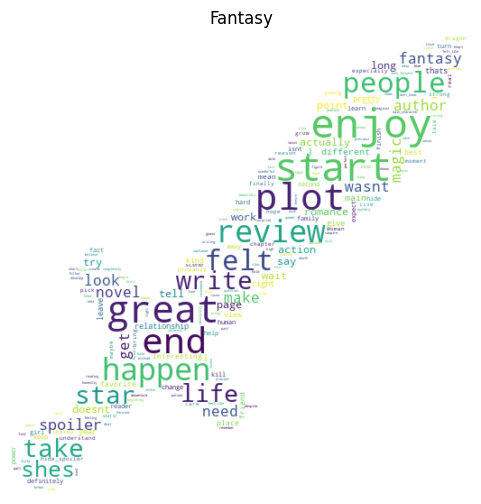

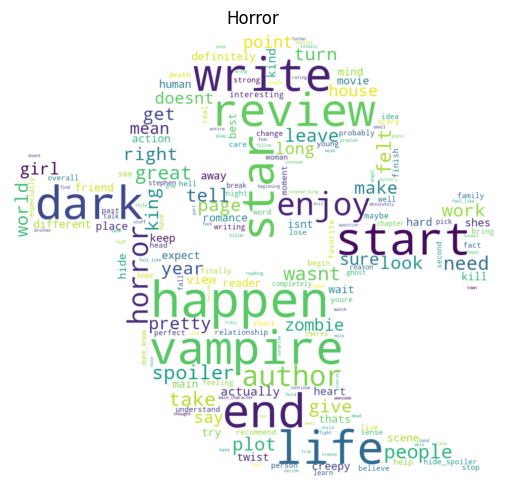

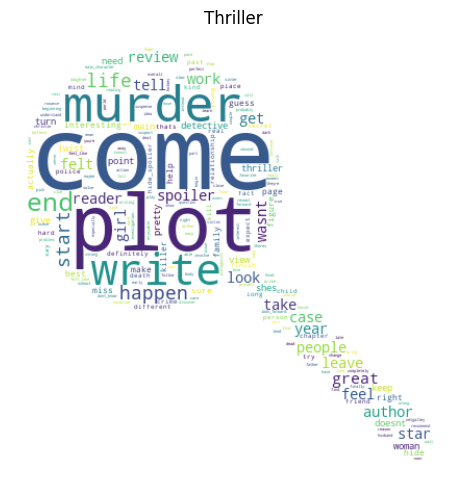

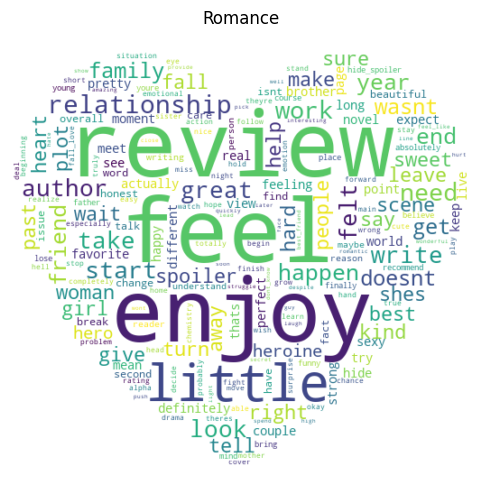

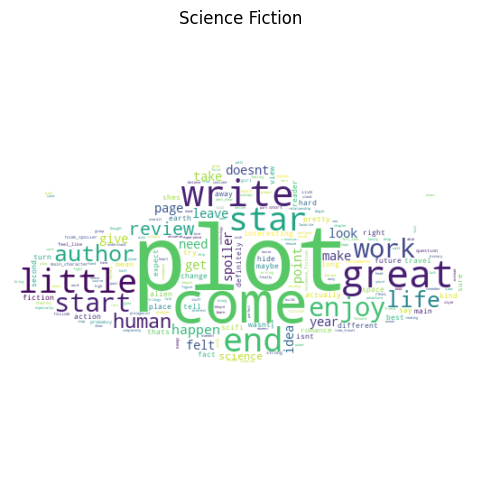

In [99]:
for genre in genre_url.keys():
    generate_wordcloud_genre(rev_df, genre)